This file is to do the main regression with graph metrics from FC. 

Currently, the regression has two steps, 

1. Regression with all features and ridge penalty, and select the siginifcant features.
    - The brain plots are based on this results

2. Regression with the selected features and ridge penalty again. 
    - The AUC is reported with this regression

I also plot the AUC for all 4 methods in this file

In [1]:
import sys
sys.path.append("/home/huaqingj/MyResearch/TVDN-AD")

In [2]:
from pyTVDN import TVDNDetect
from pathlib import Path
from scipy.io import loadmat
import numpy as np
from easydict import EasyDict as edict
import matplotlib.pyplot as plt
import os
import scipy.stats as ss
from scipy import signal
from tqdm import tqdm
import pickle
import seaborn as sns
import numbers
import scipy
import pandas as pd
import statsmodels.api as sm
%matplotlib inline

/home/huaqingj/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
import importlib
import pyTVDN.utils
importlib.reload(pyTVDN.utils)
from pyTVDN.utils import load_pkl, save_pkl

In [4]:
regionNamesRaw  ="""
ctx-lh-bankssts
ctx-lh-caudalanteriorcingulate
ctx-lh-caudalmiddlefrontal
ctx-lh-cuneus
ctx-lh-entorhinal
ctx-lh-frontalpole
ctx-lh-fusiform
ctx-lh-inferiorparietal
ctx-lh-inferiortemporal
ctx-lh-insula
ctx-lh-isthmuscingulate
ctx-lh-lateraloccipital
ctx-lh-lateralorbitofrontal
ctx-lh-lingual
ctx-lh-medialorbitofrontal
ctx-lh-middletemporal
ctx-lh-paracentral
ctx-lh-parahippocampal
ctx-lh-parsopercularis
ctx-lh-parsorbitalis
ctx-lh-parstriangularis
ctx-lh-pericalcarine
ctx-lh-postcentral
ctx-lh-posteriorcingulate
ctx-lh-precentral
ctx-lh-precuneus
ctx-lh-rostralanteriorcingulate
ctx-lh-rostralmiddlefrontal
ctx-lh-superiorfrontal
ctx-lh-superiorparietal
ctx-lh-superiortemporal
ctx-lh-supramarginal
ctx-lh-temporalpole
ctx-lh-transversetemporal
ctx-rh-bankssts
ctx-rh-caudalanteriorcingulate
ctx-rh-caudalmiddlefrontal
ctx-rh-cuneus
ctx-rh-entorhinal
ctx-rh-frontalpole
ctx-rh-fusiform
ctx-rh-inferiorparietal
ctx-rh-inferiortemporal
ctx-rh-insula
ctx-rh-isthmuscingulate
ctx-rh-lateraloccipital
ctx-rh-lateralorbitofrontal
ctx-rh-lingual
ctx-rh-medialorbitofrontal
ctx-rh-middletemporal
ctx-rh-paracentral
ctx-rh-parahippocampal
ctx-rh-parsopercularis
ctx-rh-parsorbitalis
ctx-rh-parstriangularis
ctx-rh-pericalcarine
ctx-rh-postcentral
ctx-rh-posteriorcingulate
ctx-rh-precentral
ctx-rh-precuneus
ctx-rh-rostralanteriorcingulate
ctx-rh-rostralmiddlefrontal
ctx-rh-superiorfrontal
ctx-rh-superiorparietal
ctx-rh-superiortemporal
ctx-rh-supramarginal
ctx-rh-temporalpole
ctx-rh-transversetemporal
"""
regionNames = [i.strip()[4].title() + i.strip()[6:].title() for i in regionNamesRaw.split("\n") if len(i.strip())>0]

In [5]:
os.chdir("/home/huaqingj/MyResearch/TVDN-AD/")
resDir = Path("./results")
dataDir = Path("./data")

## Load features

### Load data

In [6]:
with open("./OtherFils/KpIdxsAll.pkl", "rb") as sf:
    kpAD, kpCtrl, kpAll = pickle.load(sf)

In [7]:
# ecpts
fil = list(resDir.glob("AD_*_ecpts.pkl"))[0]
with open(fil, "rb") as f:
    ecptssAD = pickle.load(f)
fil = list(resDir.glob("Ctrl_*_ecpts.pkl"))[0]
with open(fil, "rb") as f:
    ecptssCtrl = pickle.load(f)

In [8]:
# Eigvals
fil = list(resDir.glob("AD_*_eigVals.pkl"))[0]
with open(fil, "rb") as f:
    eigValsAD = pickle.load(f)
fil = list(resDir.glob("Ctrl_*_eigVals.pkl"))[0]
with open(fil, "rb") as f:
    eigValsCtrl = pickle.load(f)

In [9]:
fil = list(resDir.glob("AD_*_eigVecs.pkl"))[0]
with open(fil, "rb") as f:
    eigVecsAD = pickle.load(f)
fil = list(resDir.glob("Ctrl_*_eigVecs.pkl"))[0]
with open(fil, "rb") as f:
    eigVecsCtrl = pickle.load(f)

In [10]:
# Sel data (only need when use sub data)
ecptssAD = [ ecptsAD for ecptsAD, kpix in zip(ecptssAD, kpAD) if kpix==1]
ecptssCtrl = [ ecptsCtrl for ecptsCtrl, kpix in zip(ecptssCtrl, kpCtrl) if kpix==1]
eigValsAD = [ v for v, kpix in zip(eigValsAD, kpAD) if kpix==1]
eigValsCtrl = [ v for v, kpix in zip(eigValsCtrl, kpCtrl) if kpix==1]
eigVecsAD = [ v for v, kpix in zip(eigVecsAD, kpAD) if kpix==1]
eigVecsCtrl = [ v for v, kpix in zip(eigVecsCtrl, kpCtrl) if kpix==1]

In [11]:
# graph metrics from TVDN
graph_fs_AD = load_pkl(resDir/"graphic_fs_AD.pkl")
graph_fs_Ctrl = load_pkl(resDir/"graphic_fs_Ctrl.pkl")

In [12]:
### The canonical networks
def minmax(x):
    num = x - np.min(x)
    den = np.max(x) - np.min(x)
    return num/den

def minmax_brainplotting(x):
    num = x - np.min(x)
    den = np.max(x) - np.min(x)
    return num/den + 1e-3

fcR = pd.read_csv('./OtherFils/DK_dic68.csv').set_index('Unnamed: 0')
rowNames = list(fcR.index)
colNames = np.array(fcR.columns)

fcRarr = np.array(fcR)

# minmax 
fcRarrMM = np.zeros_like(fcRarr)
for i, fcRar in enumerate(fcRarr):
    # minmax does not affect pearson corr
    fcRarrMM[i, :] = minmax(fcRar)

In [13]:
# calculat the topk mean of graphic feature based on dwell time
def topk_mean(topk, graphic_f, dwell, key):
    idxs = np.argsort(-dwell)[:topk]
    sel_graphic_f = np.array([graphic_f[idx][key] for idx in idxs])
    mean_v = np.mean(sel_graphic_f)
    return mean_v

### The basic data transformation 

In [15]:
# Dwell times in second
freq = 120
dwellsAD = [np.diff(np.concatenate([[0], ecpts, [7200]])/freq) for ecpts in ecptssAD]
dwellsCtrl = [np.diff(np.concatenate([[0], ecpts, [7200]])/freq) for ecpts in ecptssCtrl]

In [16]:
ecptss = ecptssAD
dwells = dwellsAD
eigVals = eigValsAD
eigVecs = eigVecsAD
graph_fs = graph_fs_AD

fsAll = []
for i in range(len(ecptss)):
    fs = edict()
    dwell = dwells[i]
    fs.dwell = dwell 
    fs.ncpts = len(ecptss[i])
    fs.meanDwell = np.mean(dwell)
    fs.maxDwell = np.max(dwell)
    fs.minDwell = np.min(dwell)
    
    eigVal = eigVals[i]
    
    fs.eigVal = eigVal
    fs.absEigValMean = np.abs(eigVal).mean()
    fs.absImagEigValMean = np.abs(np.array(eigVal).imag).mean()
    fs.absImagEigValMedian = np.median(np.abs(np.array(eigVal).imag)) # median 
    fs.absImagEigValMeanMedian = np.median(np.abs(np.array(eigVal).imag).mean(axis=1)) #mean median
    fs.absImagEigValSumMean = np.abs(np.array(eigVal).imag).sum(axis=1).mean() # sum over rank first
    fs.absImagEigValMaxMean = np.abs(np.array(eigVal).imag).max(axis=1).mean() # max over rank first
    fs.absImagEigValMedianMean = np.median(np.abs(np.array(eigVal).imag), axis=1).mean() # take median over rank first
    fs.absMaxEigValMean = np.abs(eigVal).max(axis=1).mean()
    idx = np.argmax(dwell)
    if fs.ncpts >=1:
        idx2 = np.where((-dwell).argsort().argsort()==1)[0][0]
    
    maxEigVal = eigVal[idx]
    fs.maxEigVal = maxEigVal[np.argmax(np.abs(maxEigVal))]
    fs.maxEigValMode = np.abs(maxEigVal[np.argmax(np.abs(maxEigVal))])
    fs.maxEigValReal = np.abs(maxEigVal[np.argmax(np.abs(maxEigVal))].real)
    fs.maxEigValImag = np.abs(maxEigVal[np.argmax(np.abs(maxEigVal))].imag)
    fs.maxAbsImagEigValMean = np.abs(maxEigVal.imag).mean()
    
    
    tmp = maxEigVal.copy()
    tmp[np.abs(maxEigVal) == np.max(np.abs(maxEigVal))] = 0
    fs.max2EigVal = tmp[np.argmax(np.abs(tmp))]
    fs.max2EigValMode = np.abs(tmp[np.argmax(np.abs(tmp))])
    fs.max2EigValReal = np.abs(tmp[np.argmax(np.abs(tmp))].real)
    fs.max2EigValImag = np.abs(tmp[np.argmax(np.abs(tmp))].imag)
    
    fs.maxwU = np.abs(np.matmul(eigVecs[i], maxEigVal))
    fs.wUAll = np.abs(np.matmul(eigVecs[i], np.array(eigVal).T).real)
    fs.wUAllMM = (fs.wUAll - fs.wUAll.min(axis=0))/(fs.wUAll.max(axis=0)-fs.wUAll.min(axis=0))
    fs.wUAllMMmean = fs.wUAllMM.mean(axis=1)
    fs.wUsumAll = np.abs(np.matmul(eigVecs[i], np.array(eigVal).T).real).sum(axis=1)
    fs.wUmeanAll = np.abs(np.matmul(eigVecs[i], np.array(eigVal).T).real).mean(axis=1)
    fs.maxwUraw = np.matmul(eigVecs[i], maxEigVal).real
    fs.maxwUnorm = np.linalg.norm(fs.maxwU)
    
    fs.wUcorrsAll = []
    for jx in range(fs.wUAll.shape[1]):
        curwU = fs.wUAll[:, jx]
        curwUMM = np.zeros_like(curwU)
        # curwUMM[:34] = minmax(curwU[:34])
        # curwUMM[34:] = minmax(curwU[34:])
        curwUMM[:] = minmax(curwU[:])
        curwUcorrs = []
        for ix in range(fcRarrMM.shape[0]):
            fcRarrMMcur = fcRarrMM[ix, :]
            curwUcorrs.append(ss.pearsonr(fcRarrMM[ix, :], curwUMM)[0])
        fs.wUcorrsAll.append(curwUcorrs)
    
    wUmeanMM = np.zeros_like(fs.wUmeanAll)
    # wUmeanMM[:34] = minmax(fs.wUmeanAll[:34])
    # wUmeanMM[34:] = minmax(fs.wUmeanAll[34:])
    wUmeanMM[:] = minmax(fs.wUmeanAll[:])
    fs.wUmeancorrs = []
    for ix in range(fcRarrMM.shape[0]):
        fcRarrMMcur = fcRarrMM[ix, :]
        fs.wUmeancorrs.append(ss.pearsonr(fcRarrMM[ix, :], wUmeanMM)[0])
    
    maxwUMM = np.zeros_like(fs.maxwU)
    #maxwUMM[:34] = minmax(fs.maxwU[:34])
    #maxwUMM[34:] = minmax(fs.maxwU[34:])
    maxwUMM[:] = minmax(fs.maxwU[:])
    fs.maxwUcorrs = []
    for ix in range(fcRarrMM.shape[0]):
        fcRarrMMcur = fcRarrMM[ix, :]
        fs.maxwUcorrs.append(ss.pearsonr(fcRarrMM[ix, :], maxwUMM)[0])
        
    if fs.ncpts >=1:
        fs.maxwU2 = np.abs(np.matmul(eigVecs[i], eigVal[idx2]))
        fs.maxwU2norm = np.linalg.norm(fs.maxwU2)
    else:
        fs.maxwU2 = np.zeros(fs.maxwU.shape)
        fs.maxwU2norm = 0
    
    fs.maxU = eigVecs[i][:, np.argmax(np.abs(maxEigVal))]
    fs.maxUnorm = np.linalg.norm(fs.maxU)
    fs.maxUMode = np.abs(eigVecs[i][:, np.argmax(np.abs(maxEigVal))])
    fs.maxUReal = np.abs(eigVecs[i][:, np.argmax(np.abs(maxEigVal))].real)
    fs.maxUImag = np.abs(eigVecs[i][:, np.argmax(np.abs(maxEigVal))].imag)
    maxUMM = np.zeros_like(fs.maxUMode)
    #maxUMM[:34] = minmax(fs.maxUMode[:34])
    #maxUMM[34:] = minmax(fs.maxUMode[34:])
    maxUMM[:] = minmax(fs.maxUMode[:])
    fs.maxUcorrs = []
    for ix in range(fcRarrMM.shape[0]):
        fcRarrMMcur = fcRarrMM[ix, :]
        fs.maxUcorrs.append(ss.pearsonr(fcRarrMM[ix, :], maxUMM)[0])
    
    fs.r  = len(maxEigVal)
    
    # graph metric
    graph_f = graph_fs[i]
    fs["top1_Q"] = topk_mean(1, graph_f, dwell, "tQ")
    fs["top1_C"] = topk_mean(1, graph_f, dwell, "tmC")
    fs["top1_L"] = topk_mean(1, graph_f, dwell, "tmL")
    fs["mean_Q"] = np.mean([v["tQ"] for v in graph_f])
    fs["mean_C"] = np.mean([v["tmC"] for v in graph_f])
    fs["mean_L"] = np.mean([v["tmL"] for v in graph_f])
    fs["var_Q"] = np.var([v["tQ"] for v in graph_f])
    fs["var_C"] = np.var([v["tmC"] for v in graph_f])
    fs["var_L"] = np.var([v["tmL"] for v in graph_f])
    
    fsAll.append(fs)
    
fsAD = fsAll    

In [17]:
ecptss = ecptssCtrl
dwells = dwellsCtrl
eigVals = eigValsCtrl
eigVecs = eigVecsCtrl
graph_fs = graph_fs_Ctrl

fsAll = []
for i in range(len(ecptss)):
    fs = edict()
    dwell = dwells[i]
    fs.dwell = dwell 
    fs.ncpts = len(ecptss[i])
    fs.meanDwell = np.mean(dwell)
    fs.maxDwell = np.max(dwell)
    fs.minDwell = np.min(dwell)
    
    eigVal = eigVals[i]
    
    fs.eigVal = eigVal
    fs.absEigValMean = np.abs(eigVal).mean()
    fs.absImagEigValMean = np.abs(np.array(eigVal).imag).mean()
    fs.absImagEigValMedian = np.median(np.abs(np.array(eigVal).imag)) # median 
    fs.absImagEigValMeanMedian = np.median(np.abs(np.array(eigVal).imag).mean(axis=1)) #mean median
    fs.absImagEigValSumMean = np.abs(np.array(eigVal).imag).sum(axis=1).mean() # sum over rank first
    fs.absImagEigValMaxMean = np.abs(np.array(eigVal).imag).max(axis=1).mean() # sum over rank first
    fs.absImagEigValMedianMean = np.median(np.abs(np.array(eigVal).imag), axis=1).mean() # take median over rank first
    fs.absMaxEigValMean = np.abs(eigVal).max(axis=1).mean()
    idx = np.argmax(dwell)
    if fs.ncpts >=1:
        idx2 = np.where((-dwell).argsort().argsort()==1)[0][0]
    
    maxEigVal = eigVal[idx]
    fs.maxEigVal = maxEigVal[np.argmax(np.abs(maxEigVal))]
    fs.maxEigValMode = np.abs(maxEigVal[np.argmax(np.abs(maxEigVal))])
    fs.maxEigValReal = np.abs(maxEigVal[np.argmax(np.abs(maxEigVal))].real)
    fs.maxEigValImag = np.abs(maxEigVal[np.argmax(np.abs(maxEigVal))].imag)
    fs.maxAbsImagEigValMean = np.abs(maxEigVal.imag).mean()
    
    
    tmp = maxEigVal.copy()
    tmp[np.abs(maxEigVal) == np.max(np.abs(maxEigVal))] = 0
    fs.max2EigVal = tmp[np.argmax(np.abs(tmp))]
    fs.max2EigValMode = np.abs(tmp[np.argmax(np.abs(tmp))])
    fs.max2EigValReal = np.abs(tmp[np.argmax(np.abs(tmp))].real)
    fs.max2EigValImag = np.abs(tmp[np.argmax(np.abs(tmp))].imag)
    
    fs.maxwU = np.abs(np.matmul(eigVecs[i], maxEigVal))
    fs.wUAll = np.abs(np.matmul(eigVecs[i], np.array(eigVal).T).real)
    fs.wUAllMM = (fs.wUAll - fs.wUAll.min(axis=0))/(fs.wUAll.max(axis=0)-fs.wUAll.min(axis=0))
    fs.wUAllMMmean = fs.wUAllMM.mean(axis=1)
    fs.wUsumAll = np.abs(np.matmul(eigVecs[i], np.array(eigVal).T).real).sum(axis=1)
    fs.wUmeanAll = np.abs(np.matmul(eigVecs[i], np.array(eigVal).T).real).mean(axis=1)
    fs.maxwUraw = np.matmul(eigVecs[i], maxEigVal).real
    fs.maxwUnorm = np.linalg.norm(fs.maxwU)
    
    fs.wUcorrsAll = []
    for jx in range(fs.wUAll.shape[1]):
        curwU = fs.wUAll[:, jx]
        curwUMM = np.zeros_like(curwU)
        # curwUMM[:34] = minmax(curwU[:34])
        # curwUMM[34:] = minmax(curwU[34:])
        curwUMM[:] = minmax(curwU[:])
        curwUcorrs = []
        for ix in range(fcRarrMM.shape[0]):
            fcRarrMMcur = fcRarrMM[ix, :]
            curwUcorrs.append(ss.pearsonr(fcRarrMM[ix, :], curwUMM)[0])
        fs.wUcorrsAll.append(curwUcorrs)
    
    wUmeanMM = np.zeros_like(fs.wUmeanAll)
    # wUmeanMM[:34] = minmax(fs.wUmeanAll[:34])
    # wUmeanMM[34:] = minmax(fs.wUmeanAll[34:])
    wUmeanMM[:] = minmax(fs.wUmeanAll[:])
    fs.wUmeancorrs = []
    for ix in range(fcRarrMM.shape[0]):
        fcRarrMMcur = fcRarrMM[ix, :]
        fs.wUmeancorrs.append(ss.pearsonr(fcRarrMM[ix, :], wUmeanMM)[0])
    
    maxwUMM = np.zeros_like(fs.maxwU)
    #maxwUMM[:34] = minmax(fs.maxwU[:34])
    #maxwUMM[34:] = minmax(fs.maxwU[34:])
    maxwUMM[:] = minmax(fs.maxwU[:])
    fs.maxwUcorrs = []
    for ix in range(fcRarrMM.shape[0]):
        fcRarrMMcur = fcRarrMM[ix, :]
        fs.maxwUcorrs.append(ss.pearsonr(fcRarrMM[ix, :], maxwUMM)[0])
        
    if fs.ncpts >=1:
        fs.maxwU2 = np.abs(np.matmul(eigVecs[i], eigVal[idx2]))
        fs.maxwU2norm = np.linalg.norm(fs.maxwU2)
    else:
        fs.maxwU2 = np.zeros(fs.maxwU.shape)
        fs.maxwU2norm = 0
    
    fs.maxU = eigVecs[i][:, np.argmax(np.abs(maxEigVal))]
    fs.maxUnorm = np.linalg.norm(fs.maxU)
    fs.maxUMode = np.abs(eigVecs[i][:, np.argmax(np.abs(maxEigVal))])
    fs.maxUReal = np.abs(eigVecs[i][:, np.argmax(np.abs(maxEigVal))].real)
    fs.maxUImag = np.abs(eigVecs[i][:, np.argmax(np.abs(maxEigVal))].imag)
    maxUMM = np.zeros_like(fs.maxUMode)
    #maxUMM[:34] = minmax(fs.maxUMode[:34])
    #maxUMM[34:] = minmax(fs.maxUMode[34:])
    maxUMM[:] = minmax(fs.maxUMode[:])
    fs.maxUcorrs = []
    for ix in range(fcRarrMM.shape[0]):
        fcRarrMMcur = fcRarrMM[ix, :]
        fs.maxUcorrs.append(ss.pearsonr(fcRarrMM[ix, :], maxUMM)[0])
    
    fs.r  = len(maxEigVal)
    
    # graph metric
    graph_f = graph_fs[i]
    fs["top1_Q"] = topk_mean(1, graph_f, dwell, "tQ")
    fs["top1_C"] = topk_mean(1, graph_f, dwell, "tmC")
    fs["top1_L"] = topk_mean(1, graph_f, dwell, "tmL")
    fs["mean_Q"] = np.mean([v["tQ"] for v in graph_f])
    fs["mean_C"] = np.mean([v["tmC"] for v in graph_f])
    fs["mean_L"] = np.mean([v["tmL"] for v in graph_f])
    fs["var_Q"] = np.var([v["tQ"] for v in graph_f])
    fs["var_C"] = np.var([v["tmC"] for v in graph_f])
    fs["var_L"] = np.var([v["tmL"] for v in graph_f])
    
    
    fsAll.append(fs)
    
fsCtrl = fsAll    

### Save the feature for brain plot

In [18]:
def U2BrainVec(wU):
    emVec = np.zeros_like(DKtmplate, dtype=np.float64)
    for idx in range(1, 69):
        emVec[DKtmplate==idx] = wU[idx-1]
    return emVec

def reorderU(wU):
    wUreorder = np.zeros_like(wU, dtype=np.float64)
    wUreorder[0::2] = wU[:34]
    wUreorder[1::2] = wU[34:]
    return wUreorder

In [19]:
with open("./OtherFils/BNVtemplate_DK68.txt", "r") as tf:
    DKtmplateRaw = tf.readlines()
DKtmplate = np.array([int(x.strip()) for x in DKtmplateRaw])

##  Regression in TVDN

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import roc_auc_score, roc_curve

import matplotlib.cbook as cbook
import statsmodels.api as sm

from sklearn.cluster import KMeans, SpectralClustering
from scipy.stats import fisher_exact, norm
from prettytable import PrettyTable as pTB
from sklearn.metrics import f1_score
from collections import defaultdict as ddict


from sklearn.cluster import SpectralClustering, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from scipy.stats import chi2_contingency
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

In [22]:
def TuningCFn(inpX, inpY, Cs=[0.1, 0.2, 0.4, 0.8, 1, 1.6, 3.2, 6.4, 12.8, 25.6], penalty="l2"):
    aucCs = []
    for C in Cs:
        eProbs = []
        loo = LeaveOneOut()
        for trIdxs, testIdxs in loo.split(inpX):
            clf = LogisticRegression(penalty=penalty, random_state=0, C=C)
            clf.fit(inpX[trIdxs, :], inpY[trIdxs])
            eProbs.append(clf.predict_proba(inpX[testIdxs, :]))
        eProbs = np.array(eProbs).squeeze()
        auc = roc_auc_score(inpY, eProbs[:, 1])
        fpr, tpr, thresholds = roc_curve(inpY, eProbs[:, 1], pos_label=1)
        aucCs.append(auc)
            
    optC = Cs[np.argmax(aucCs)]
    res = edict()
    res["optC"] = optC
    res["Cs"] = Cs
    res["aucCs"] = aucCs
    return res

In [24]:
# save the csv file for all reg data
Ys = np.concatenate([np.ones(len(fsAD)), np.zeros(len(fsCtrl))])
fsName = ["r", "ncpts", "absImagEigValMaxMean", 
          "top1_Q", "top1_C", "top1_L", 
          "var_Q",  "var_C",  "var_L",  
          "wUmeanAll" ]
XsAD = []
XsCtrl = []
for fName in fsName:
    if isinstance(fsAD[0][fName], numbers.Number):
        cfAD = np.array([fs[fName] for fs in fsAD]).reshape(-1, 1)
        cfCtrl = np.array([fs[fName] for fs in fsCtrl]).reshape(-1, 1)
    else:
        cfAD = np.array([fs[fName] for fs in fsAD])
        cfCtrl = np.array([fs[fName] for fs in fsCtrl])
    
    XsAD.append(cfAD)
    XsCtrl.append(cfCtrl)
XsAD = np.concatenate(XsAD, axis=1)
XsCtrl = np.concatenate(XsCtrl, axis=1)
Xs = np.concatenate([XsAD, XsCtrl], axis=0)

data_full = np.concatenate([Ys.reshape(-1, 1), Xs], axis=1)
data_full = pd.DataFrame(data_full, columns=["Y"]+fsName[:-1]+regionNames)
data_full.to_csv(resDir/"TVDN_full_data.csv", index=False)

In [50]:
penalty = "l2"
Ys = np.concatenate([np.ones(len(fsAD)), np.zeros(len(fsCtrl))])
# past
#fsName = ["r", "ncpts", #"absImagEigValMaxMean", 
#          "top1_Q", "top1_C", "top1_L", 
#          #"mean_Q",  "mean_C",  "mean_L",  
#          "var_Q",  "var_C",  "var_L",  
#          "wUmeanAll" ]
fsName = ["r", "ncpts", #"absImagEigValMaxMean", 
          #"top1_Q", "top1_L", 
          "mean_Q",  "mean_L",  
          "var_Q",  "var_L",  
          "wUmeanAll" ]
XsAD = []
XsCtrl = []
for fName in fsName:
    if isinstance(fsAD[0][fName], numbers.Number):
        cfAD = np.array([fs[fName] for fs in fsAD]).reshape(-1, 1)
        cfCtrl = np.array([fs[fName] for fs in fsCtrl]).reshape(-1, 1)
    else:
        cfAD = np.array([fs[fName] for fs in fsAD])
        cfCtrl = np.array([fs[fName] for fs in fsCtrl])
    
    XsAD.append(cfAD)
    XsCtrl.append(cfCtrl)
XsAD = np.concatenate(XsAD, axis=1)
XsCtrl = np.concatenate(XsCtrl, axis=1)
Xs = np.concatenate([XsAD, XsCtrl], axis=0)
stdXs = (Xs - Xs.mean(axis=0))/Xs.std(axis=0)

# name prefix to save the results
preFix = "_".join(fsName) + f"_{penalty}"
Cs = [0.1, 0.2, 0.4, 0.8, 1, 1.6, 3.2, 6.4, 12.8, 25.6]
print(preFix)

r_ncpts_mean_Q_mean_L_var_Q_var_L_wUmeanAll_l2


<AxesSubplot:>

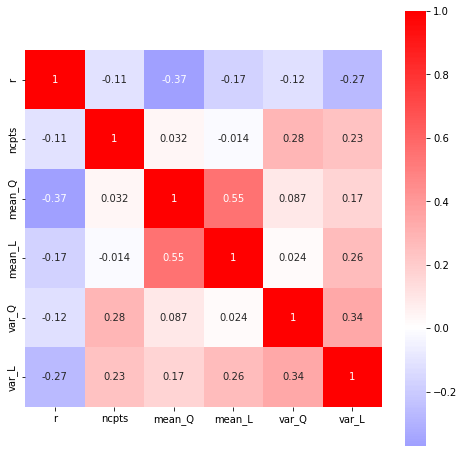

In [51]:
# corr mat for 9 fs
part_Xs = Xs[:, :-68]
corr_mat = np.corrcoef(part_Xs.T)
plt.figure(figsize=[8, 8])
sns.heatmap(corr_mat, cmap="bwr", 
            xticklabels=fsName[:-1],
            yticklabels=fsName[:-1],
            square=True,
            annot=np.round(corr_mat, 3),
            center=0)

In [129]:
# save data
save_data_TVDN = {"stdXs":stdXs, "Ys":Ys}
save_pkl(resDir/"tmp_res/TVDN_data.pkl", save_data_TVDN)

results/tmp_res/TVDN_data.pkl exists! Use is_force=True to save it anyway


### First reg (select features)

including

- features selection

#### Fit model

In [52]:
# The opTuningC will be used throughout
gOptC = TuningCFn(stdXs, Ys, Cs, penalty=penalty)["optC"]
print(gOptC)

0.4


In [53]:
# fit the first reg
clfFinal = LogisticRegression(penalty=penalty, random_state=0, C=gOptC)
clfFinal.fit(stdXs, Ys)
coefsFinal = clfFinal.coef_.reshape(-1)

#### Bootstrap for pvals

I use Bootstrap to select finally as it has better results

We can also calculate the pvalue based on bootstrap by assuming, under $H_0$, $\beta \sim N(0, \sigma^2)$. 

In [54]:
np.random.seed(0)
repTime = 10000
parassBoot = []
for i in tqdm(range(repTime)):
    bootIdx = np.random.choice(len(Ys), len(Ys))
    YsBoot = Ys[bootIdx]
    stdXsBoot = stdXs[bootIdx]
    clf = LogisticRegression(penalty=penalty, random_state=0, C=gOptC)
    clf.fit(stdXsBoot, YsBoot)
    parasBoot = clf.coef_.reshape(-1)
    parassBoot.append(parasBoot)

100%|██████████| 10000/10000 [00:15<00:00, 649.88it/s]


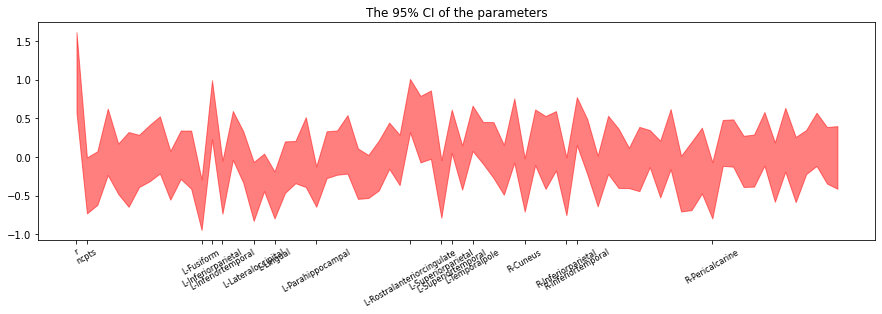

In [55]:
parassBoot = np.array(parassBoot)
#lows, ups = np.quantile(parassBoot[:, :], [0.025, 0.975], axis=0)
lows, ups = coefsFinal-parassBoot.std(axis=0)*1.96, coefsFinal+parassBoot.std(axis=0)*1.96
kpidxBoot = np.bitwise_or(lows >0,  ups < 0)
kpidxIdBoot = np.where(kpidxBoot)[0]

xlabs = np.concatenate([fsName[:-1],
                         regionNames])
plt.figure(figsize=[15, 4])
plt.fill_between(list(range(len(lows))), lows, ups, color="red", alpha=.5)
plt.title("The 95% CI of the parameters")
_ = plt.xticks(kpidxIdBoot, xlabs[kpidxIdBoot], rotation=30, fontsize=8)

select_fs_idx = kpidxBoot

In [56]:
# Pvalue
testStatsBoot = coefsFinal/parassBoot.std(axis=0)
#testStatsBoot = parassBoot.mean(axis=0)/parassBoot.std(axis=0)
normRV = norm()
# to be consistent, I think we should use two-sided pvalue
bootPvs = 2*(1-normRV.cdf(np.abs(testStatsBoot)))
bootPvs

array([3.87053329e-05, 4.60171469e-02, 1.22321855e-01, 3.72304231e-01,
       3.58414477e-01, 5.13361890e-01, 7.64570197e-01, 7.95970656e-01,
       4.07822180e-01, 1.40090600e-01, 8.58217266e-01, 8.54968835e-01,
       1.97202101e-04, 1.76138012e-03, 2.49160451e-02, 8.43577521e-02,
       9.95294536e-01, 2.18934003e-02, 1.06701548e-01, 1.53596678e-03,
       4.37220085e-01, 6.33970339e-01, 7.85754117e-01, 4.07540007e-03,
       8.51377851e-01, 7.00097530e-01, 3.98692421e-01, 1.93693647e-01,
       7.52716259e-02, 4.99054370e-01, 3.40144268e-01, 8.15743036e-01,
       1.60637468e-04, 1.00870649e-01, 6.33679865e-02, 2.94143970e-02,
       2.01132505e-02, 3.46645852e-01, 1.34003578e-02, 1.87203989e-01,
       6.24733495e-01, 3.13111868e-01, 1.07567272e-01, 4.04326022e-02,
       1.66890198e-01, 8.09212857e-01, 2.85573503e-01, 4.64999052e-02,
       3.44482690e-03, 4.59437523e-01, 6.23059951e-02, 4.13501069e-01,
       9.30364311e-01, 2.87244633e-01, 8.99954179e-01, 3.76714485e-01,
      

In [38]:
# Bootstrap p value and CI are consistent
tmpIdx = np.bitwise_xor(bootPvs <= 0.05, kpidxBoot)
resDic = {
   "Feature" : xlabs[tmpIdx],  
    "Parameters": coefsFinal[tmpIdx],
    "Lower": lows[tmpIdx],
    "Upper": ups[tmpIdx],
    "Pvalues": bootPvs[tmpIdx]
}
pd.set_option("display.precision", 3)
resDF = pd.DataFrame(resDic)
print(resDF)

Empty DataFrame
Columns: [Feature, Parameters, Lower, Upper, Pvalues]
Index: []


#### The output table 

In [57]:
resDic = {
   "Feature" : xlabs[kpidxBoot],  
    "Parameters": coefsFinal[kpidxBoot],
    "Lower": lows[kpidxBoot],
    "Upper": ups[kpidxBoot],
    "Pvalues": bootPvs[kpidxBoot]
}
#pd.set_option("display.precision", 3)
pd.set_option('display.float_format',lambda x : '%.3e' % x)
resDF = pd.DataFrame(resDic)
print(resDF)

                       Feature  Parameters      Lower      Upper   Pvalues
0                            r   1.093e+00  5.724e-01  1.613e+00 3.871e-05
1                        ncpts  -3.686e-01 -7.307e-01 -6.510e-03 4.602e-02
2                   L-Fusiform  -6.187e-01 -9.444e-01 -2.929e-01 1.972e-04
3           L-Inferiorparietal   6.106e-01  2.280e-01  9.932e-01 1.761e-03
4           L-Inferiortemporal  -3.918e-01 -7.343e-01 -4.939e-02 2.492e-02
5           L-Lateraloccipital  -4.459e-01 -8.272e-01 -6.463e-02 2.189e-02
6                    L-Lingual  -4.921e-01 -7.965e-01 -1.876e-01 1.536e-03
7            L-Parahippocampal  -3.833e-01 -6.449e-01 -1.217e-01 4.075e-03
8   L-Rostralanteriorcingulate   6.645e-01  3.194e-01  1.010e+00 1.606e-04
9           L-Superiorparietal  -4.139e-01 -7.864e-01 -4.141e-02 2.941e-02
10          L-Superiortemporal   3.322e-01  5.207e-02  6.124e-01 2.011e-02
11              L-Temporalpole   3.705e-01  7.685e-02  6.641e-01 1.340e-02
12                    R-C

In [58]:
abs_paras = np.array(resDF["Parameters"].abs())
raw_bds = np.array(resDF[["Lower", "Upper"]].abs())
abs_low_bd = np.min(raw_bds, axis=1)
abs_up_bd = np.max(raw_bds, axis=1)
pvs = np.array(resDF["Pvalues"])
outDF = {"Features": np.array(resDF["Feature"]),
        "Params": abs_paras, 
        "Lower":abs_low_bd, 
        "Upper":abs_up_bd, 
        "Pvals":pvs}
outDF = pd.DataFrame(outDF)
print(outDF.to_latex(float_format="{:0.3f}".format))

\begin{tabular}{llrrrr}
\toprule
{} &                    Features &  Params &  Lower &  Upper &  Pvals \\
\midrule
0  &                           r &   1.093 &  0.572 &  1.613 &  0.000 \\
1  &                       ncpts &   0.369 &  0.007 &  0.731 &  0.046 \\
2  &                  L-Fusiform &   0.619 &  0.293 &  0.944 &  0.000 \\
3  &          L-Inferiorparietal &   0.611 &  0.228 &  0.993 &  0.002 \\
4  &          L-Inferiortemporal &   0.392 &  0.049 &  0.734 &  0.025 \\
5  &          L-Lateraloccipital &   0.446 &  0.065 &  0.827 &  0.022 \\
6  &                   L-Lingual &   0.492 &  0.188 &  0.797 &  0.002 \\
7  &           L-Parahippocampal &   0.383 &  0.122 &  0.645 &  0.004 \\
8  &  L-Rostralanteriorcingulate &   0.665 &  0.319 &  1.010 &  0.000 \\
9  &          L-Superiorparietal &   0.414 &  0.041 &  0.786 &  0.029 \\
10 &          L-Superiortemporal &   0.332 &  0.052 &  0.612 &  0.020 \\
11 &              L-Temporalpole &   0.370 &  0.077 &  0.664 &  0.013 \\
12 &     

In [63]:
fsDic = {
   "Feature" : xlabs[:-68],  
    "Parameters": coefsFinal[:-68],
    "Lower": lows[:-68],
    "Upper": ups[:-68],
    "Pvalues": bootPvs[:-68]
}
#pd.set_option("display.precision", 3)
pd.set_option('display.float_format',lambda x : '%.3e' % x)
fsDF = pd.DataFrame(fsDic)
print(fsDF.to_latex(float_format="{:0.3f}".format))

\begin{tabular}{llrrrr}
\toprule
{} & Feature &  Parameters &  Lower &  Upper &  Pvalues \\
\midrule
0 &       r &       1.093 &  0.572 &  1.613 &    0.000 \\
1 &   ncpts &      -0.369 & -0.731 & -0.007 &    0.046 \\
2 &  mean\_Q &      -0.273 & -0.620 &  0.073 &    0.122 \\
3 &  mean\_L &       0.196 & -0.234 &  0.626 &    0.372 \\
4 &   var\_Q &      -0.153 & -0.478 &  0.173 &    0.358 \\
5 &   var\_L &      -0.161 & -0.645 &  0.323 &    0.513 \\
\bottomrule
\end{tabular}



In [64]:
# save brain
# final parameter, abs, remove pv <0.05
tmp_n = len(fsName[:]) - 1
oPParas = minmax(np.abs(coefsFinal[tmp_n:]))
NLogPvs = -np.log10(bootPvs[tmp_n:])
oPParas[NLogPvs < -np.log10(0.05)] = 0
outOPParas = U2BrainVec(reorderU(oPParas))

np.savetxt(f"./brainPlotFils/{preFix}_reg1_finalabsOPParas.txt", outOPParas)
pd.DataFrame({"Name": regionNames,
              "Vec": oPParas}).to_csv(f"./brainPlotFils/{preFix}_reg1_finalabsOPParas.csv", index=False)

In [74]:
np.sort(oPParas)

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.49920943,
       0.54302721, 0.55686299, 0.57083105, 0.57618043, 0.58901621,
       0.62228241, 0.6493124 , 0.67054834, 0.69654532, 0.74007223,
       0.91866985, 0.93088569, 1.        ])

### Second reg

(AUC)

In [67]:
# select fs
stdXs_selected = stdXs[:, select_fs_idx]
stdXs_selected.shape

(176, 16)

In [68]:
gOptC2 = TuningCFn(stdXs_selected, Ys, Cs, penalty=penalty)["optC"]
print(gOptC2)

3.2


In [69]:
eProbs = []
loo = LeaveOneOut()
parass = []
curOptCs = []
with tqdm(total=len(Ys)) as t:
    for trIdxs, testIdxs in loo.split(stdXs_selected):
        curStdXs, curYs = stdXs_selected[trIdxs, :], Ys[trIdxs]
        curOptC = TuningCFn(curStdXs, curYs, Cs, penalty=penalty)["optC"]
        curOptCs.append(curOptC)
        clf = LogisticRegression(penalty=penalty, random_state=0, C=curOptC)
        clf.fit(curStdXs, curYs)
        paras = clf.coef_.reshape(-1)
        parass.append(paras)
        eProbs.append(clf.predict_proba(stdXs_selected[testIdxs, :]))
        
        t.update()
eProbs = np.array(eProbs).squeeze()
gAuc = roc_auc_score(Ys, eProbs[:, 1])
gFpr, gTpr, thresholds = roc_curve(Ys, eProbs[:, 1], pos_label=1)
parass = np.array(parass)
print(gAuc)

with open(resDir/f"TVDN_ROCcurve_reg2_{preFix}.pkl", "wb") as f:
    resROC = {"fpr":gFpr, "tpr":gTpr, "AUC":gAuc, "curOptCs":curOptCs}
    pickle.dump(resROC, f)

100%|██████████| 176/176 [03:34<00:00,  1.22s/it]

0.8424586776859505


In [70]:
np.random.seed(0)
nobs = stdXs_selected.shape[0]
Aucss = []
for j in tqdm(range(10000)):
    testIdx = np.random.choice(nobs, int(nobs/5), False)
    trainIdx = np.delete(np.arange(nobs), testIdx)
    clf = LogisticRegression(penalty=penalty, random_state=0, C=gOptC2)
    clf.fit(stdXs_selected[trainIdx], Ys[trainIdx])
    curEprobs = clf.predict_proba(stdXs_selected[testIdx, :])
    curAuc = roc_auc_score(Ys[testIdx], curEprobs[:, 1])
    Aucss.append(curAuc)
mAUC = np.mean(Aucss)
stdAUC = np.std(Aucss)
print(f"The mean of AUC under 1000 repetitions is {mAUC:.3f} and the standard deviation is {stdAUC:.3f}, "
      f"the 95% CI is ({np.quantile(Aucss, 0.025):.3f}, {np.quantile(Aucss, 0.975):.3f}).")

100%|██████████| 10000/10000 [00:12<00:00, 821.68it/s]

The mean of AUC under 1000 repetitions is 0.843 and the standard deviation is 0.064, the 95% CI is (0.706, 0.953).


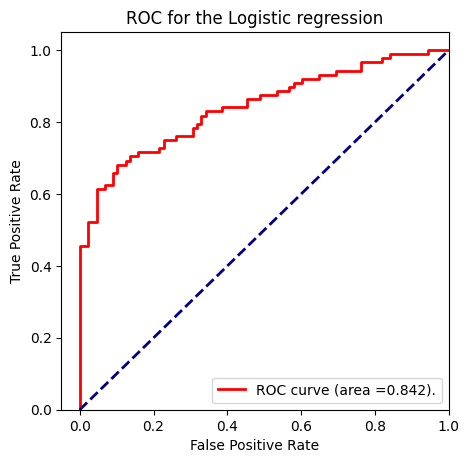

In [71]:
plt.figure(figsize=[5, 5], dpi=100)
plt.plot(gFpr, gTpr, label=f"ROC curve (area ={gAuc:.3f}).", lw=2, color="red")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC for the Logistic regression")
plt.legend(loc="lower right")
#plt.savefig(f"./plots/{preFix}_roc.jpg", bbox_inches='tight')

## Combine all results in figs



In [75]:
rocAll = {}
rocAll['TVDN'] = load_pkl(resDir/"TVDN_ROCcurve_reg2_r_ncpts_mean_Q_mean_L_var_Q_var_L_wUmeanAll_l2.pkl")
rocAll['TVDMD'] = load_pkl(resDir/"TVDMD_ROCcurve_reg2_r_ncpts_mean_Q_mean_L_var_Q_var_L_wUmeanAll_l2.pkl")
rocAll['ND'] = load_pkl(resDir/"ND_ROCcurve_reg2_r_tQ_tL_wU.pkl")
rocAll['DMD'] = load_pkl(resDir/"DMD_ROCcurve_reg2_r_tQ_tL_wU.pkl")

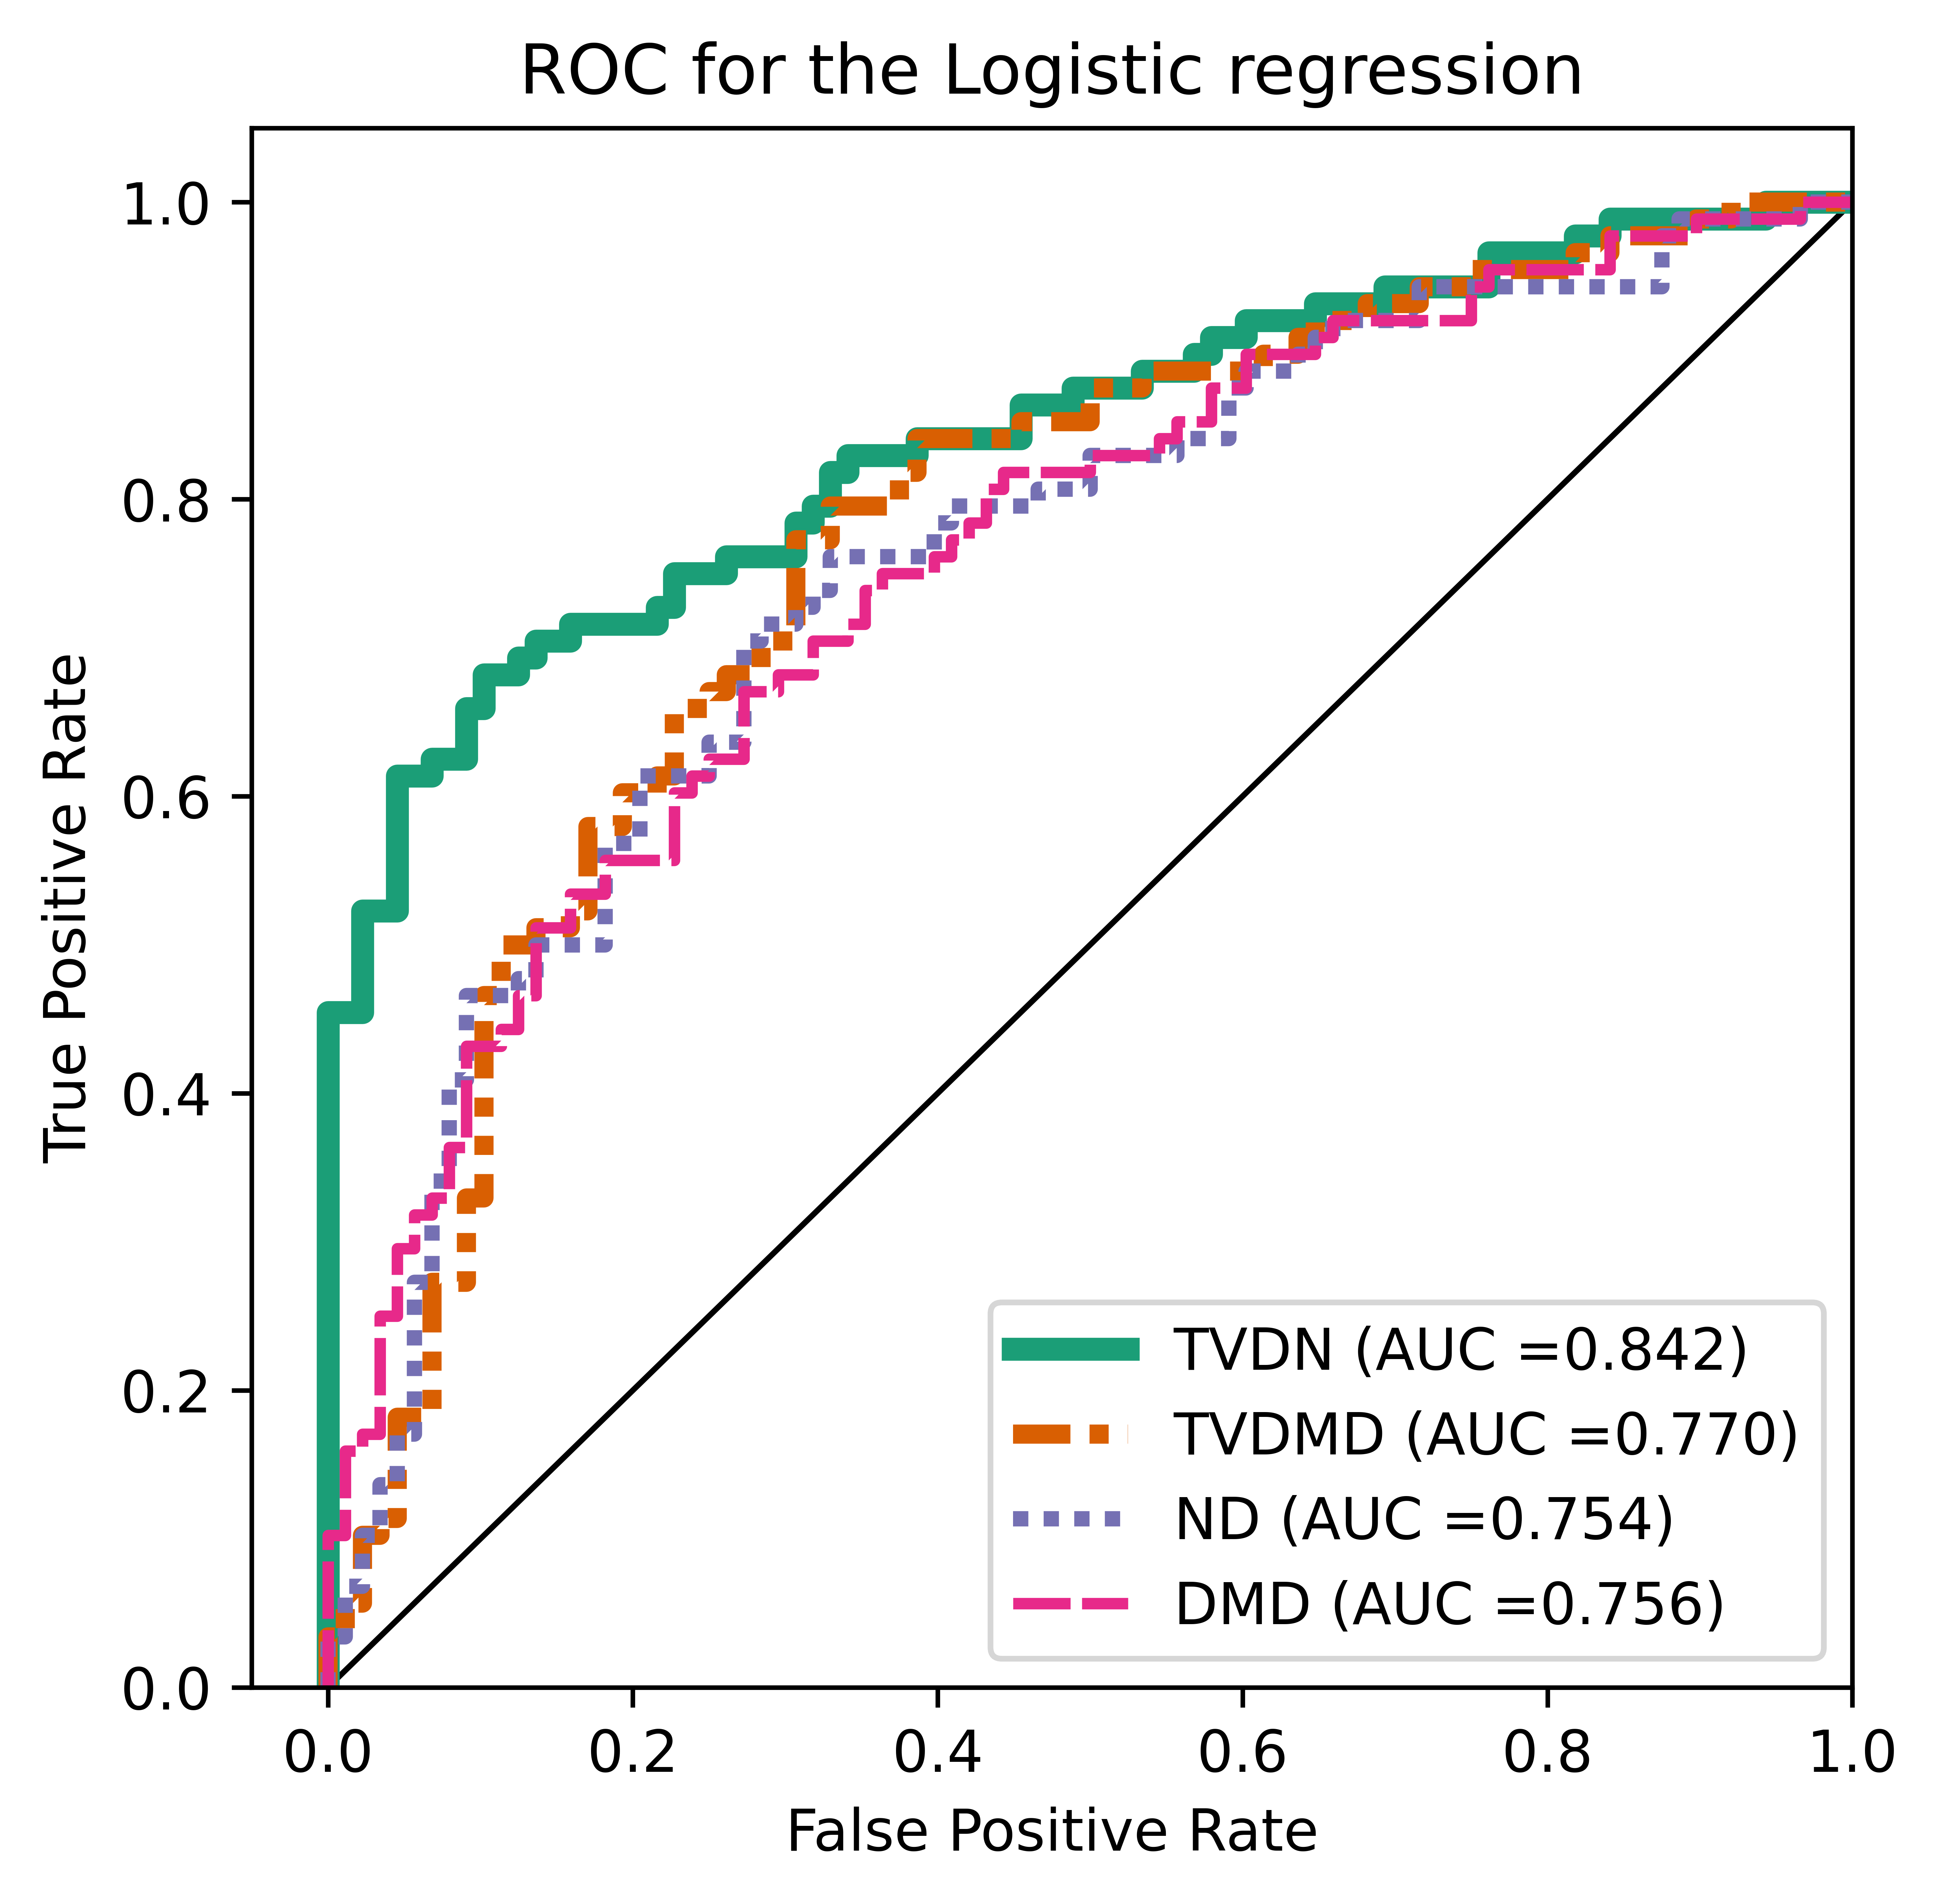

In [76]:
lss = [
     ("line", "-"),
     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1))),
     ('densely dotted',        (0, (1, 1))),
     #('long dash with offset', (5, (10, 3))),
     ('densely dashed',        (0, (5, 1))),
     #('densely dashdotted',    (0, (3, 1, 1, 1))),
]
import seaborn as sns
#cols = sns.color_palette(None, len(rocAll))
#cols =["#e41a1c", "#377eb8", "#4daf4a", "#984ea3", "#ff7f00", "#ffff33",]
cols = [ "#1b9e77", "#d95f02", "#7570b3", "#e7298a", "#66a61e", "#e6ab02",]
markers = ["o", "h", "s", "*", "^", "+"]
lws = np.linspace(4, 2, 4)
plt.figure(figsize=[5, 5], dpi=1200)
plt.plot([0, 1], [0, 1], color="black", lw=1, linestyle="-")
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC for the Logistic regression")
flag = 0
for key, v in rocAll.items():
    plt.plot(v["fpr"], v["tpr"], label=f"{key} (AUC ={v['AUC']:.3f})", 
             lw=lws[flag], color=cols[flag], linestyle=lss[flag][1])#, marker=markers[flag])
    flag += 1
plt.legend(loc="lower right")
plt.savefig(f"./plots/double_reg_rocAll.jpg", bbox_inches='tight')